In [1]:
import warnings

import numpy
import pandas 
import clickhouse_connect
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore')
plt.style.use('dark_background') 

/home/devil/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/devil/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
class clickhouse:
	def __init__(self):
		self.client = clickhouse_connect.get_client(
                            host='iebo4f3e4z.asia-southeast1.gcp.clickhouse.cloud',
                            user='default',
                            password='I8_AuX5WqWwGC',
                            secure=True)
	def data_cleaner(self, data):
		for i in zip(data.columns,data.dtypes):
		    if i[1]=='O':
		        data[i[0]] = data[i[0]].fillna('Unknown')
		    else:
		        data[i[0]] = data[i[0]].fillna(0)
		return data

	def table_creater(self, data, database_name):
		columns = ""
		for i in zip(data.columns,data.dtypes):
		    if i[1]=='O':
		        columns += f'{i[0]} String, '
		    else:
		        columns += f'{i[0]} Float64, '
		#print(data.dtypes)
		#print(f'CREATE TABLE {database_name} ({columns}) Engine MergeTree ORDER BY ID')
		self.client.command(f'CREATE TABLE {database_name} ({columns}) Engine MergeTree ORDER BY ID')
		self.client.insert(database_name, data.to_numpy(), column_names=list(data.columns))

	def table_reader(self, database_name):
		train, columns = {}, [i for i in self.client.command(f'DESC {database_name}') if i!='' and i!='String' and i!='Float64']
		columns = [columns[0]]+[i.split('\n')[1] for i in columns[1:]]
		for i in columns:
			train[i] = numpy.array(self.client.command(f'SELECT top 10000 {i} FROM {database_name}').split('\n'))
		return pandas.DataFrame(train, columns = columns)

In [3]:
class data_ploter:
    def __init__(self, labels, type_):
        plt.figure(figsize=(12, 7))
        
        if type_=='single_label_plot':
            plt.title(f'{labels[0]}')
            label = data_ploter.label_extracter(self, labels[0])
            plt.bar(label.keys(), label.values())
            
        elif type_=='double_label_plot':            
            label = data_ploter.two_label_extracter(self, labels[0],labels[1])
            if type(list(label.keys())[0])==str:
                plt.plot(label.keys(), label.values(), marker='o')
            else:
                plt.bar(label.keys(), label.values())
            plt.xlabel(labels[0])
            plt.ylabel(labels[1])
            
        elif type_=='normal_plot': 
            if len(labels)==1:
                plt.title(f'{labels[0]}')
                plt.plot(data[labels[0]].to_numpy())
                
            elif len(labels)==2:     
                label = data_ploter.two_label_extracter(self, labels[0],labels[1])           
                plt.bar(label.keys(), label.values())
                plt.xlabel(labels[0])
                plt.ylabel(labels[1])
            
    def label_extracter(self, label):
        label_count = {}
        for i in data[label]:
            if i not in label_count.keys():
                label_count[i]=1
            else:
                label_count[i]+=1
        return label_count
        
    def two_label_extracter(self, label_1, label_2):
        label_count = {}
        for i in zip(data[label_1],data[label_2]):
            if i[0] not in label_count.keys():
                label_count[i[0]]=i[1]
            else:
                label_count[i[0]]+=i[1]
        return label_count


In [4]:
#data = pandas.read_csv('sales_train.csv')

In [5]:
#house = clickhouse()
#data['ID'] = data['unique_id']
#house.table_creater(data.drop(columns=['unique_id']), 'Sales')

In [6]:
data = pandas.read_csv('sales_train.csv') #house.table_reader('Sales')

In [7]:
data['date_1'] = data['date'].astype('datetime64[ns]')

data['date'] = data['date_1']#.dt.strftime('%Y.%m%d').astype('float64')

data["day"] = data['date_1'].dt.day
data["month"] = data['date_1'].dt.month
data["year"] = data['date_1'].dt.year

In [8]:
data

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,date_1,day,month,year
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0,2024-03-10,10,3,2024
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,2021-05-25,25,5,2021
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,2021-12-20,20,12,2021
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0,2023-04-29,29,4,2023
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0,2022-04-01,1,4,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4007414,4941,2023-06-21,Prague_1,9988.0,26.56,34.06,1.00,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,2023-06-21,21,6,2023
4007415,4941,2023-06-24,Prague_1,8518.0,27.42,34.06,1.00,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,2023-06-24,24,6,2023
4007416,4941,2023-06-23,Prague_1,10424.0,33.39,34.06,1.00,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,2023-06-23,23,6,2023
4007417,4941,2023-06-22,Prague_1,10342.0,22.88,34.06,1.00,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,2023-06-22,22,6,2023


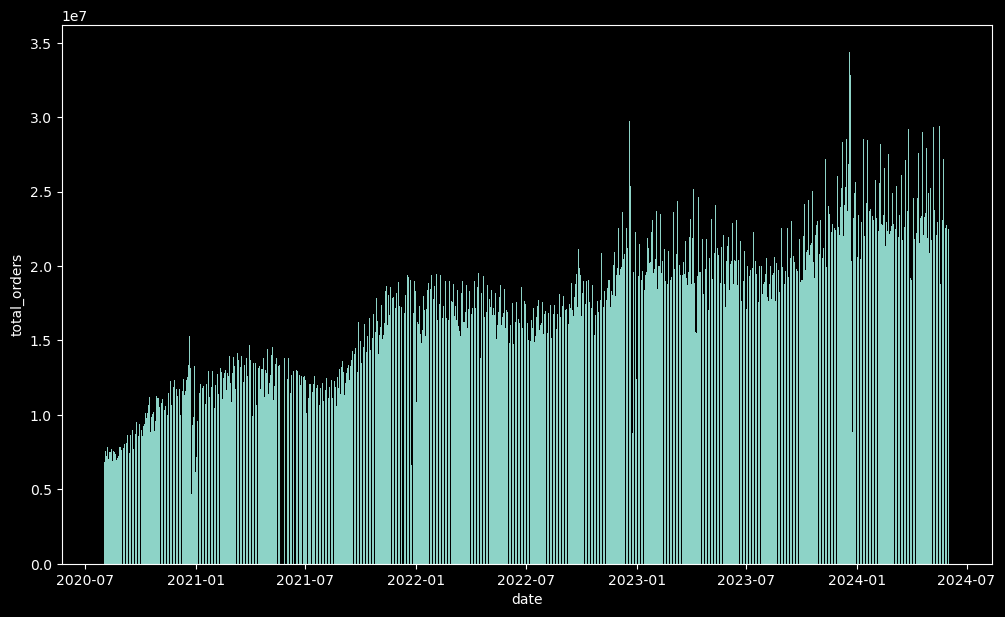

In [9]:
data_ploter(['date', 'total_orders'], 'normal_plot')

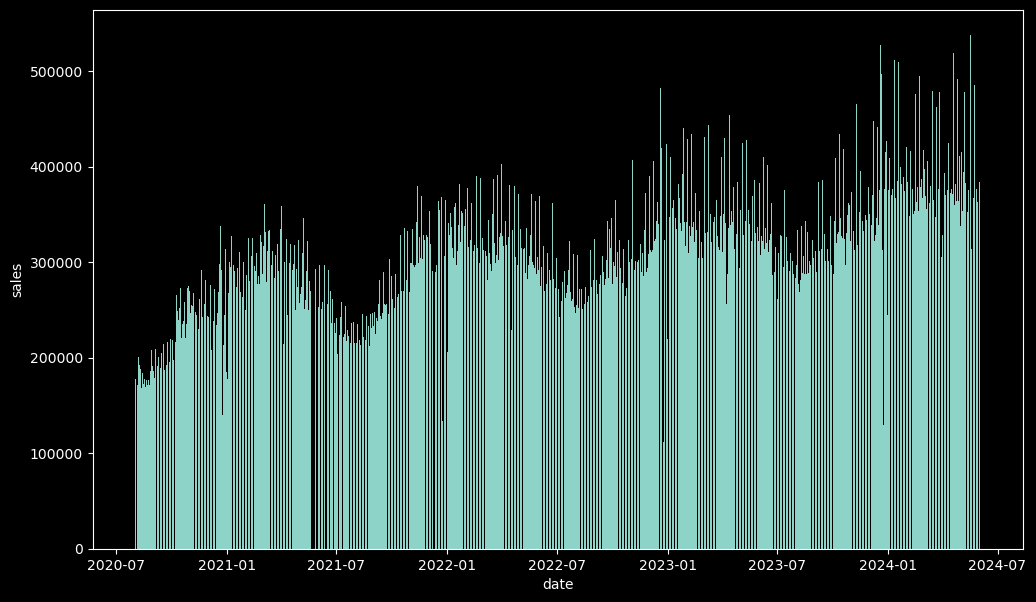

In [10]:
data_ploter(['date', 'sales'], 'normal_plot')

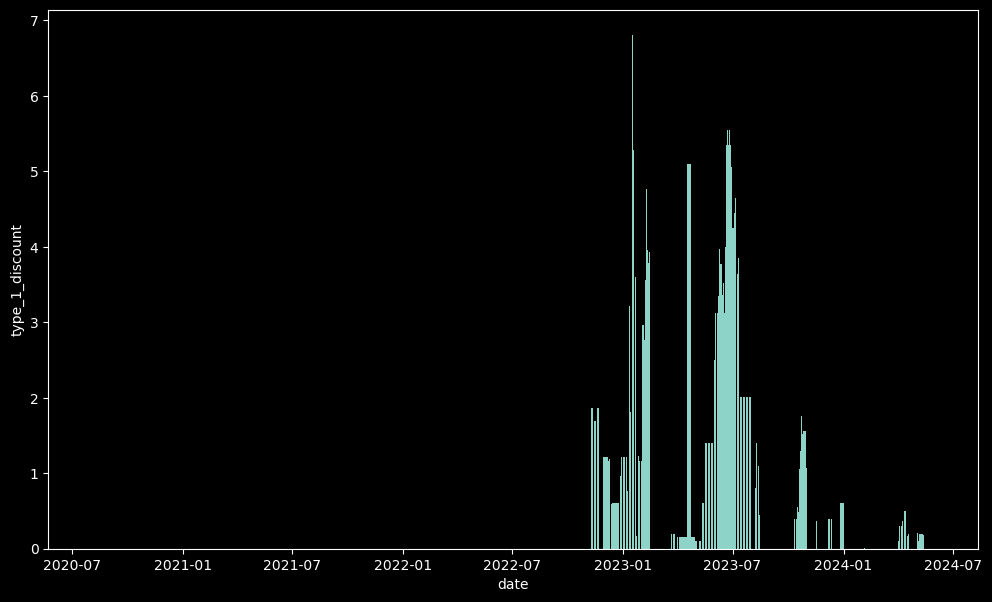

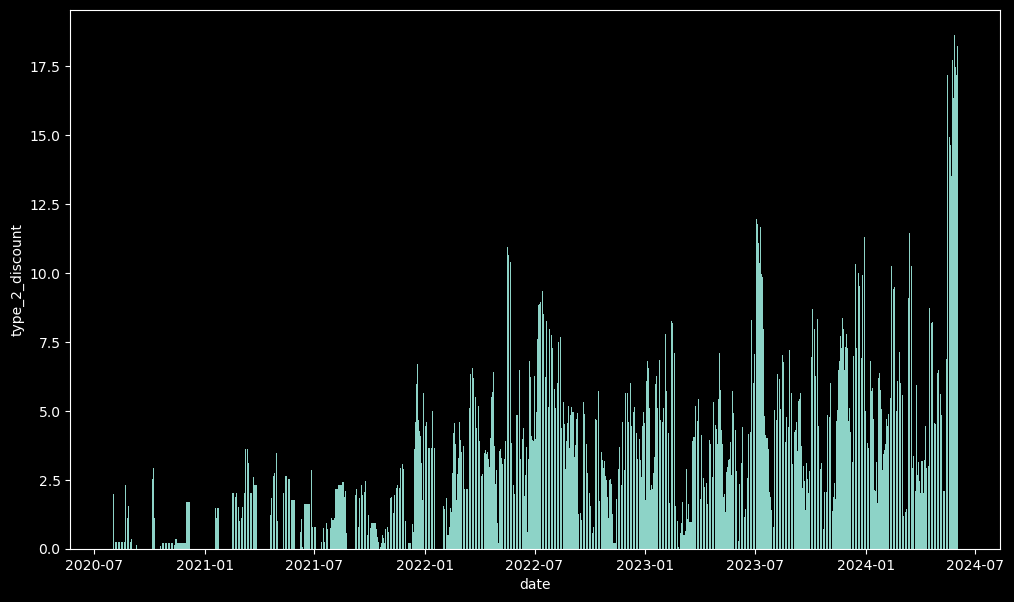

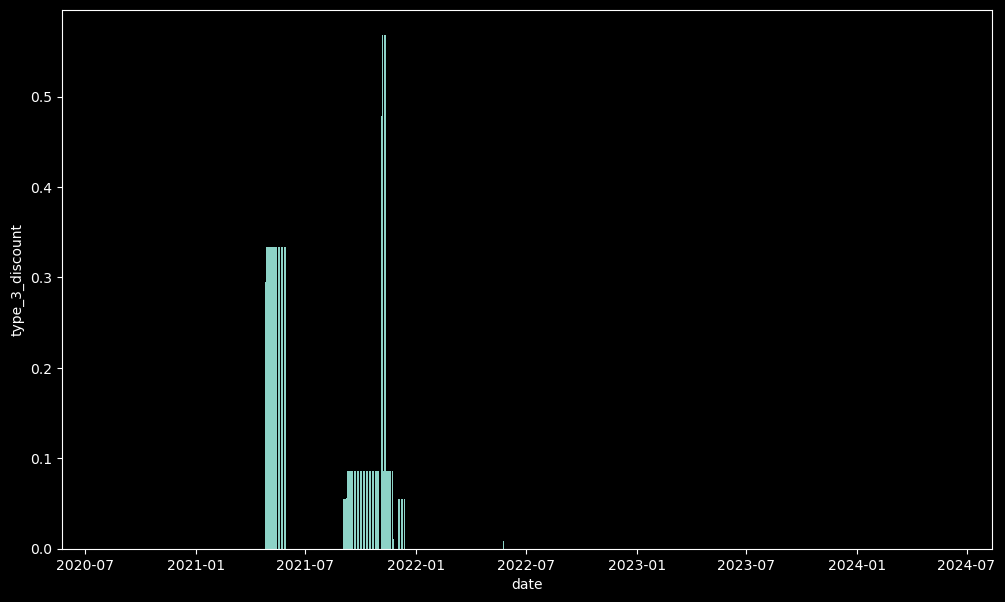

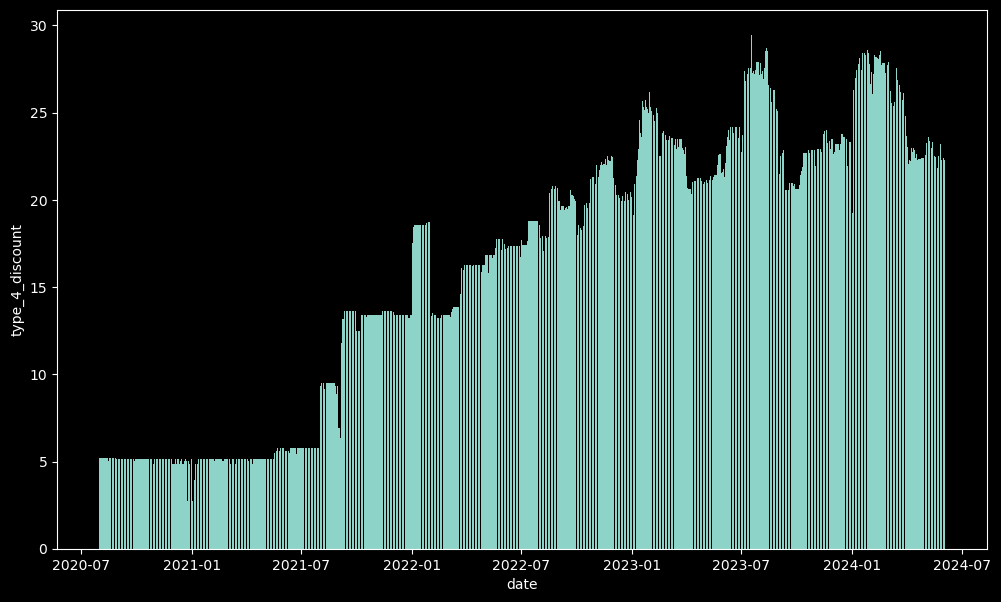

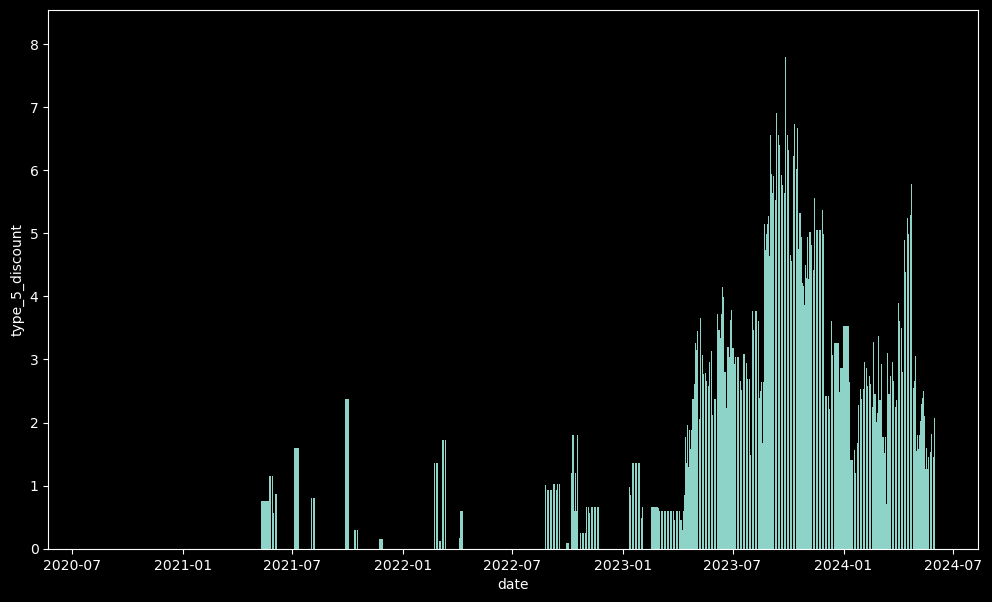

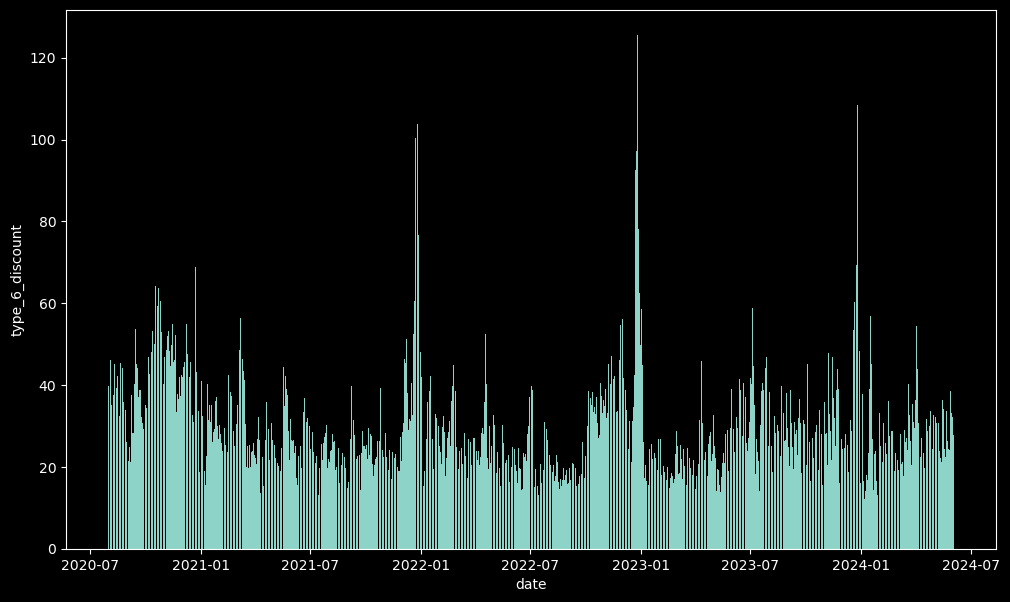

In [11]:
data_ploter(['date', 'type_1_discount'], 'normal_plot')
data_ploter(['date', 'type_2_discount'], 'normal_plot')
data_ploter(['date', 'type_3_discount'], 'normal_plot')
data_ploter(['date', 'type_4_discount'], 'normal_plot')
data_ploter(['date', 'type_5_discount'], 'normal_plot')
data_ploter(['date', 'type_6_discount'], 'normal_plot')

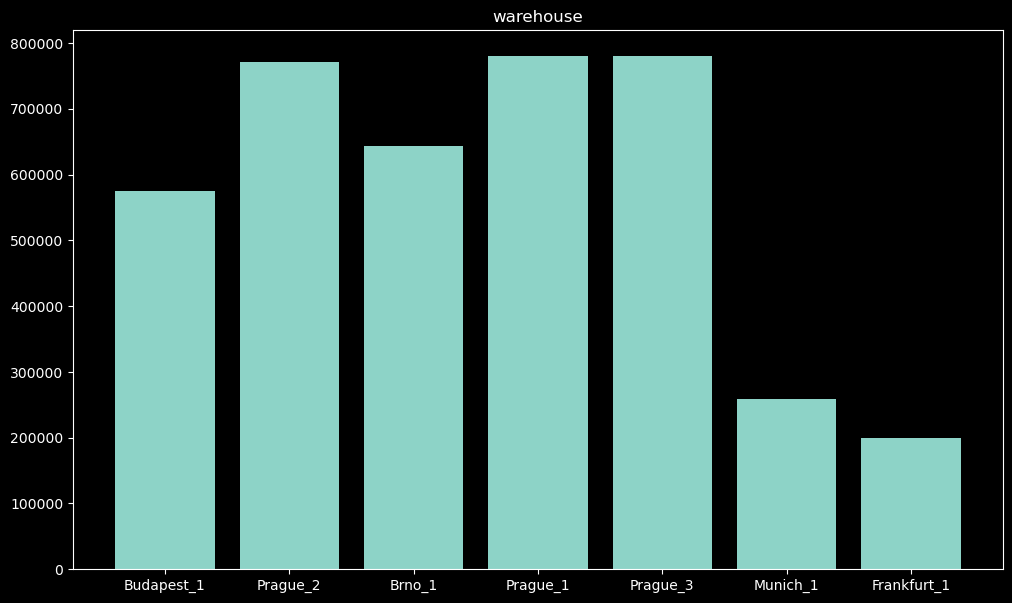

In [12]:
data_ploter(['warehouse'], 'single_label_plot')

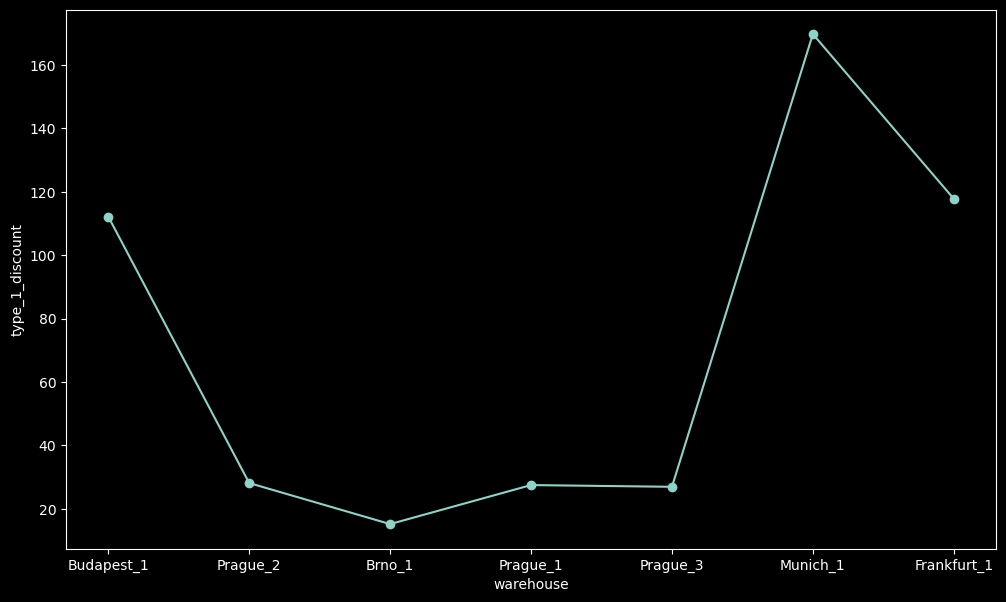

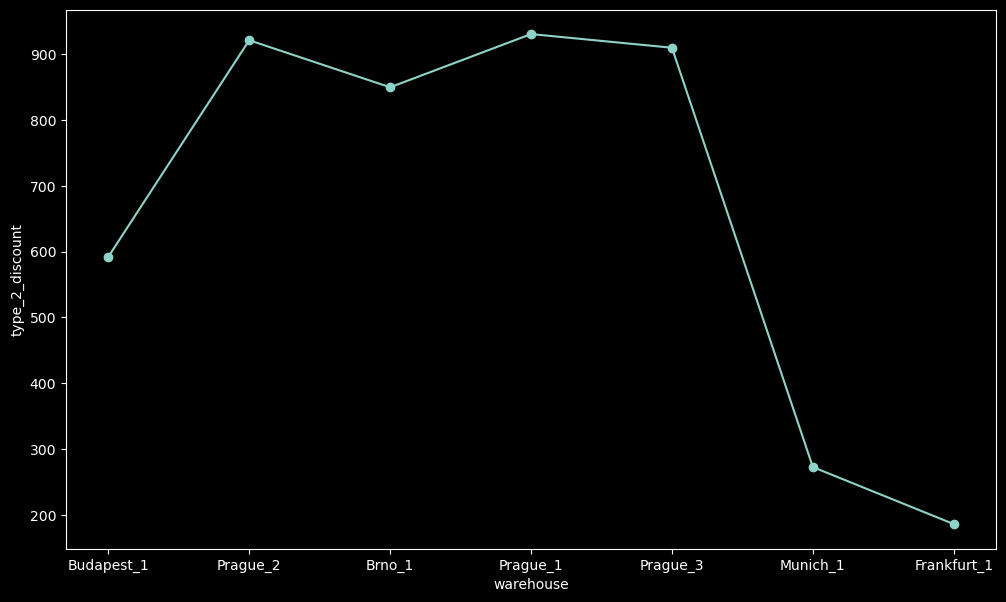

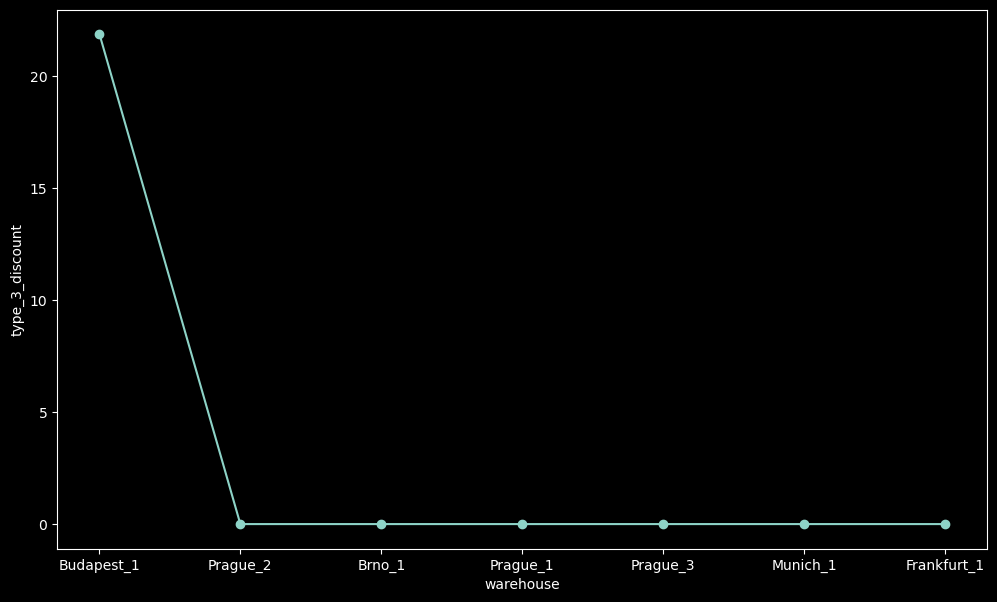

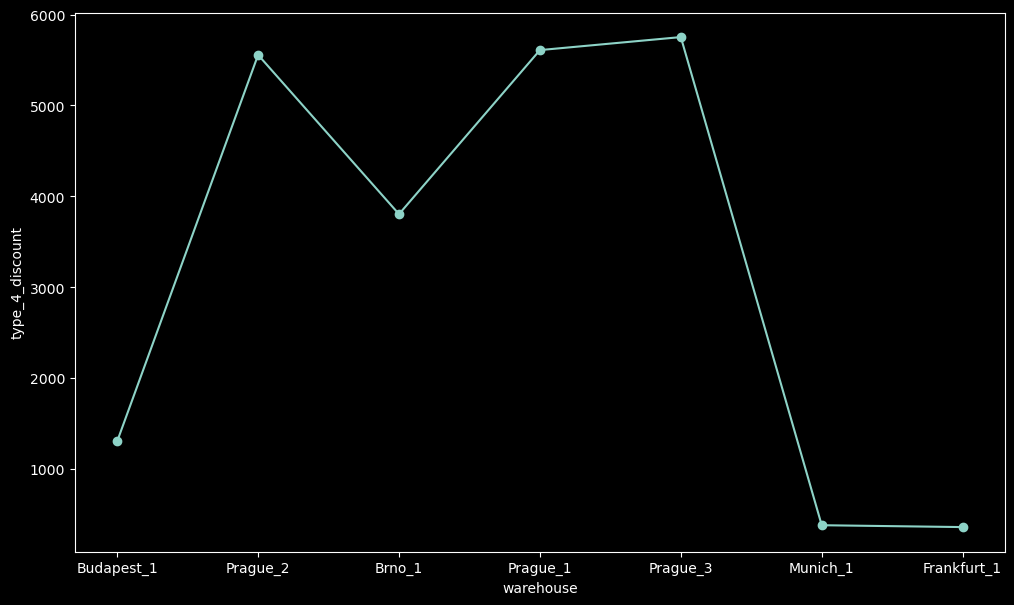

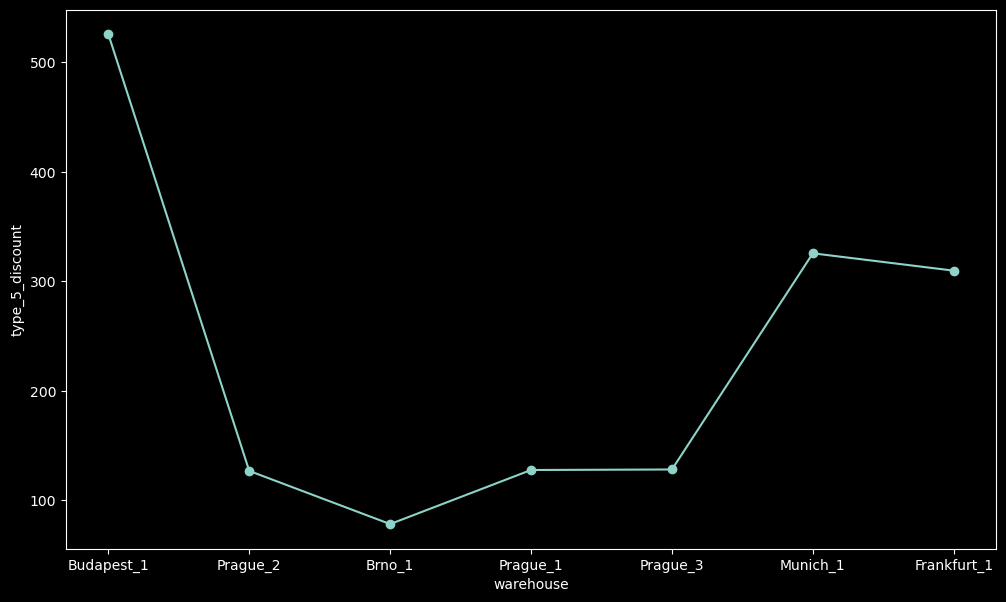

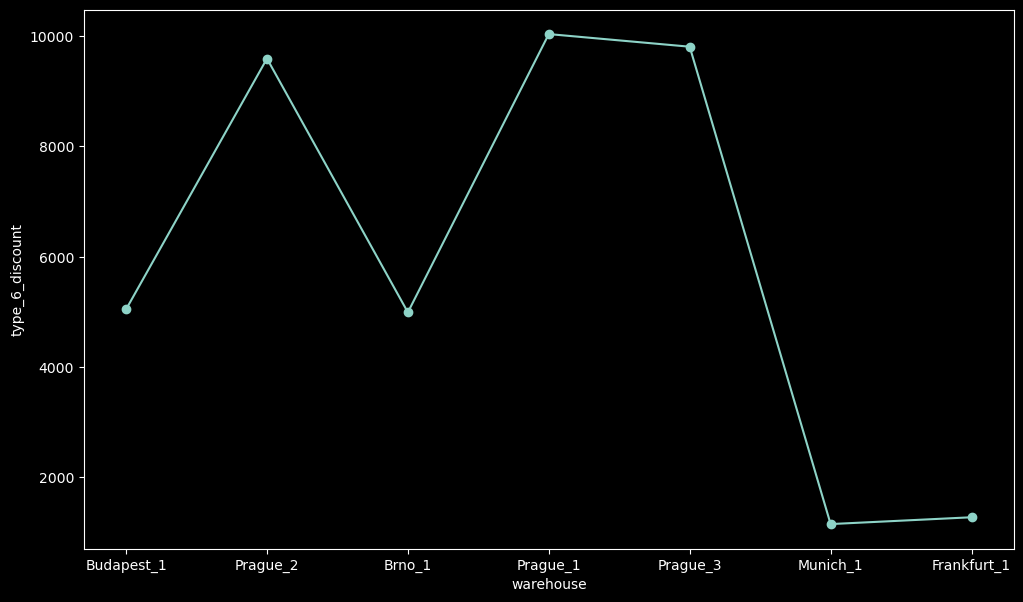

In [13]:
data_ploter(['warehouse', 'type_1_discount'], 'double_label_plot')
data_ploter(['warehouse', 'type_2_discount'], 'double_label_plot')
data_ploter(['warehouse', 'type_3_discount'], 'double_label_plot')
data_ploter(['warehouse', 'type_4_discount'], 'double_label_plot')
data_ploter(['warehouse', 'type_5_discount'], 'double_label_plot')
data_ploter(['warehouse', 'type_6_discount'], 'double_label_plot')


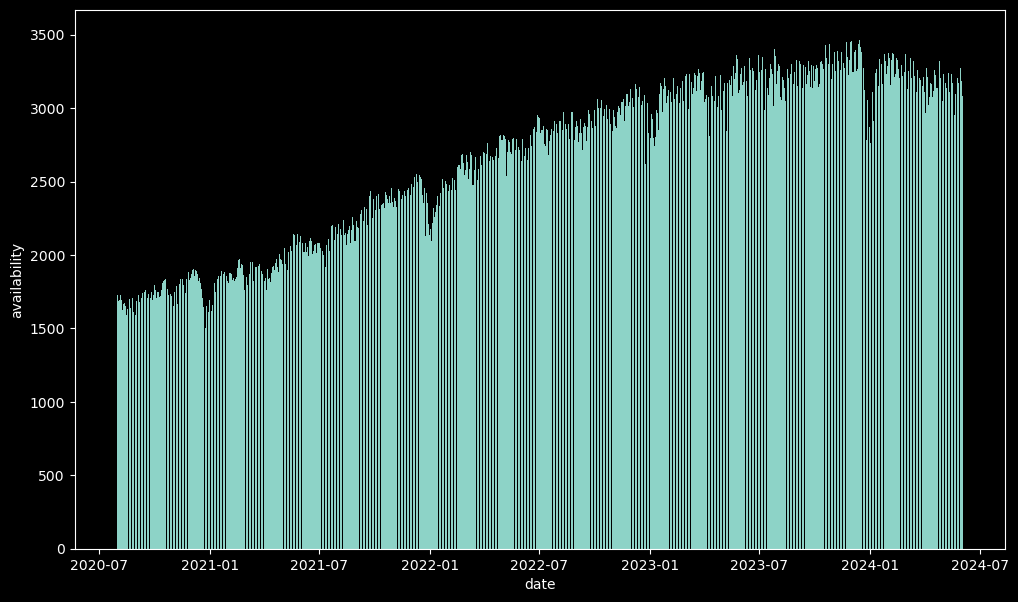

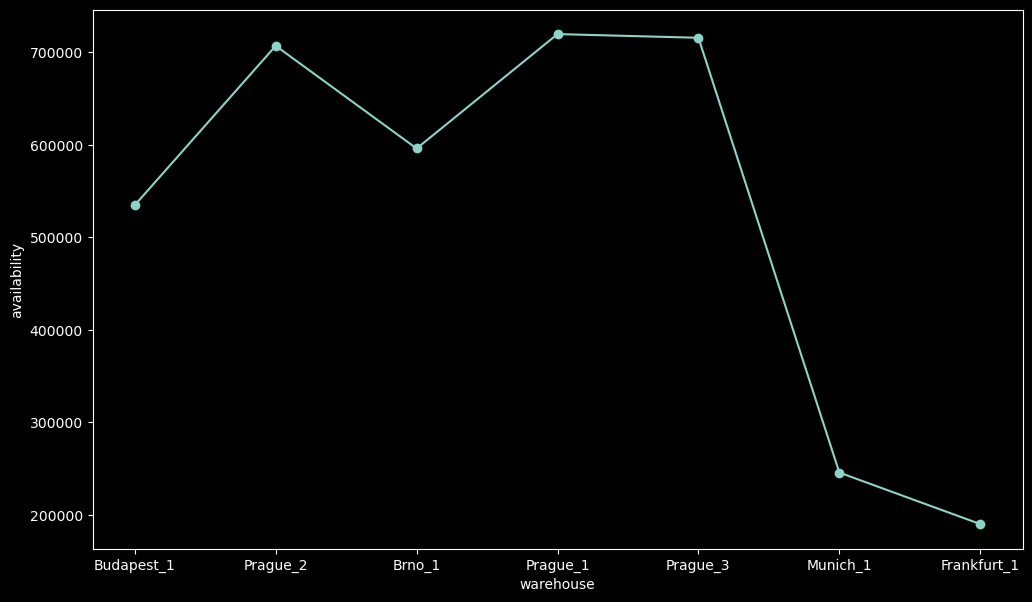

In [14]:
data_ploter(['date', 'availability'], 'double_label_plot')
data_ploter(['warehouse', 'availability'], 'double_label_plot')